In [ ]:
#按照SMILES 区分训练集和数据集

In [1]:

# 基础库
import numpy as np
import pandas as pd
import random
from collections import Counter
from tqdm import tqdm
import warnings

# 可视化
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# 机器学习相关
from sklearn.model_selection import ParameterSampler, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import clone
from sklearn.exceptions import ConvergenceWarning, FitFailedWarning
from sklearn.decomposition import PCA

# 机器学习模型
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 深度学习相关
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset

# 数据不平衡处理
from imblearn.over_sampling import RandomOverSampler

# 统计分析
from scipy.stats import pearsonr, norm

In [2]:
data=pd.read_excel("./fish_unique.xlsx")
data=data.dropna()
smiles_data = data['SMILES_Canonical_RDKit'].tolist()
mgperL = data['mgperL'].values
Duration_Value= data['Duration_Value'].values

In [3]:
smiles_embeddings = np.load('./fish_unique_smiles_embeddings.npy')

In [4]:
endpoint = data['endpoint']
mgperL=np.log1p(mgperL)

In [5]:
def plot_fold_change_histogram_symmetric(y_true, y_pred):
    # 计算 fold change：预测值相对于真实值的倍数
    fold_change_pos = y_pred[y_pred >= y_true] / y_true[y_pred >= y_true]  # 预测值大于真实值
    fold_change_neg = y_true[y_pred < y_true] / y_pred[y_pred < y_true]    # 预测值小于真实值

    # 合并数据并生成单一的对数间隔
    fold_change_combined = np.concatenate((1/fold_change_neg, fold_change_pos))
    bins = np.logspace(-3, 3, 150)  # 增加分辨率，使用150个区间
    plt.figure(figsize=(10, 6))

    # 绘制直方图
    plt.hist(fold_change_combined, bins=bins,color='#662B92', edgecolor='black', alpha=0.7, 
             label="Residual Error (Prediction vs Actual)", rwidth=0.9)  # rwidth 调整间隙

    # 添加对数刻度和中心的1
    plt.xscale('log')
    plt.xlabel("Prediction error (fold change)", fontsize=14)
    plt.ylabel("Count", fontsize=14)

    # 添加大于特定倍数误差的百分比标记
    thresholds = [10, 100, 1000]
    total_count_pos = len(fold_change_pos)
    total_count_neg = len(fold_change_neg)
    total_count_all = total_count_neg + total_count_pos
    
    for threshold in thresholds:
        # 计算右侧误差大于特定阈值的数量和百分比
        count_above_pos = np.sum(fold_change_pos > threshold)
        percentage_pos = (count_above_pos / total_count_all) * 100
        
        # 计算左侧误差大于特定阈值的数量和百分比
        count_above_neg = np.sum(fold_change_neg > threshold)
        percentage_neg = (count_above_neg / total_count_all) * 100
        
        # 在右侧标注阈值线和百分比
        plt.axvline(threshold, color='black', linestyle='--', linewidth=1)
        plt.text(threshold, plt.ylim()[1] * 0.8, f"{percentage_pos:.1f}%", color="black", ha="center", fontsize=10)

        # 在左侧标注阈值线和百分比
        plt.axvline(1/threshold, color='black', linestyle='--', linewidth=1)
        plt.text(1/threshold, plt.ylim()[1] * 0.8, f"{percentage_neg:.1f}%", color="black", ha="center", fontsize=10)

    # 设置 x 轴的对称 log 刻度
    plt.xticks([1e-3, 1e-2, 1e-1, 1, 10, 100, 1000], ["1000", "100", "10", "1", "10", "100", "1000"])

    # 去除上边框和右边框
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.show()

In [6]:
def perform_random_search_cv(model, param_grid, X, y, smiles, endpoints, X_embeddings, n_iter=20, n_splits=10):
    # 确保输入数据为 NumPy 数组
    X = np.array(X)
    y = np.array(y)
    smiles = np.array(smiles)
    endpoints = np.array(endpoints)
    X_embeddings = np.array(X_embeddings)
    
    param_iter = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=42))
    best_score = float('-inf')  # 用于选取最高的加权分数
    best_params = None
    best_y_true, best_y_pred = [], []  # 保存最优参数对应的验证集结果
    best_similarity_scores = []  # 保存最优参数对应的相似度
    best_errors = []  # 保存最优参数对应的误差
    best_endpoint_errors = {}  # 保存最优参数对应的 endpoint 误差
    best_smiles_embeddings = []  # 保存最优参数对应的 embeddings

    with tqdm(total=len(param_iter), desc="Hyperparameter Search", mininterval=1.0) as pbar:
        for params in param_iter:
            fold_r2_scores = []
            fold_mse = []

            # 使用 GroupKFold 确保每一折的训练集和验证集 SMILES 不重叠
            gkf = GroupKFold(n_splits=n_splits)

            # 临时变量存储当前参数的结果
            current_y_true, current_y_pred = [], []
            current_similarity_scores = []
            current_errors = []
            current_endpoint_errors = {}
            current_smiles_embeddings = []

            for train_index, val_index in gkf.split(X, y, groups=smiles):
                # 划分训练集和验证集
                X_fold_train, X_fold_val = X[train_index], X[val_index]
                y_fold_train, y_fold_val = y[train_index], y[val_index]
                X_fold_train_embeddings, X_fold_val_embeddings = X_embeddings[train_index], X_embeddings[val_index]
                smiles_fold_train = smiles[train_index]

                # 标准化特征
                scaler_X = StandardScaler()
                X_fold_train = scaler_X.fit_transform(X_fold_train)
                X_fold_val = scaler_X.transform(X_fold_val)

                # 训练模型
                temp_model = clone(model)
                temp_model.set_params(**params)
                temp_model.fit(X_fold_train, y_fold_train)

                # 验证集预测
                y_pred = temp_model.predict(X_fold_val)
                mse = mean_squared_error(y_fold_val, y_pred)
                fold_mse.append(mse)
                r2 = r2_score(y_fold_val, y_pred)
                fold_r2_scores.append(r2)

                # 保存当前折的结果
                current_y_true.extend(y_fold_val)
                current_y_pred.extend(y_pred)
                current_smiles_embeddings.extend(X_fold_val_embeddings)

                # 计算余弦相似度
                similarities = cosine_similarity(X_fold_val_embeddings, X_fold_train_embeddings)
                mean_similarities = similarities.mean(axis=1)
                current_similarity_scores.extend(mean_similarities)

                # 记录误差（绝对误差）
                error = np.abs(y_fold_val - y_pred)
                current_errors.extend(error)

                # 记录每个 endpoint 的误差
                endpoints_val = endpoints[val_index]
                for endpoint in np.unique(endpoints_val):
                    endpoint_mask = (endpoints_val == endpoint)
                    endpoint_y_true = y_fold_val[endpoint_mask]
                    endpoint_y_pred = y_pred[endpoint_mask]
                    endpoint_error = np.abs(endpoint_y_true - endpoint_y_pred)
                    if endpoint not in current_endpoint_errors:
                        current_endpoint_errors[endpoint] = []
                    current_endpoint_errors[endpoint].extend(endpoint_error)

            avg_r2 = np.mean(fold_r2_scores)
            avg_mse = np.mean(fold_mse)

            # 加权指标，这里您可以根据需要调整权重组合方式
            weighted_score = avg_r2 - avg_mse
            if weighted_score > best_score:
                # 更新最优参数及其对应的验证结果
                best_score = weighted_score
                best_params = params
                best_y_true = current_y_true
                best_y_pred = current_y_pred
                best_similarity_scores = current_similarity_scores
                best_errors = current_errors
                best_endpoint_errors = current_endpoint_errors
                best_smiles_embeddings = current_smiles_embeddings

            pbar.update(1)

    return best_params, best_similarity_scores, best_errors, best_y_true, best_y_pred, best_endpoint_errors, best_smiles_embeddings


# 定义计算绝对误差的函数
def absolute_error(y_true, y_pred):
    return np.abs(y_true - y_pred)

In [7]:
# 检查需要One-Hot编码的列，并进行编码（如果类别超过一种）
def encode_column(data, column_name):
    unique_values = data[column_name].unique()
    if len(unique_values) > 1:
        encoder = OneHotEncoder(sparse_output=False)
        return encoder.fit_transform(data[[column_name]])
    else:
        return None  # 只有一种类别时忽略

# 编码 effect、endpoint 和 species_group 列
effect_encoded = encode_column(data, 'effect')
endpoint_encoded = encode_column(data, 'endpoint')
species_encoded = encode_column(data, 'species_group')

# 将需要的列拼接成输入 X
X = np.hstack((smiles_embeddings, data['Duration_Value'].values.reshape(-1, 1)))

# 拼接编码后的列（如果存在）
for encoded_feature in [effect_encoded, endpoint_encoded, species_encoded]:
    if encoded_feature is not None:
        X = np.hstack((X, encoded_feature))

# 目标值 y
y = mgperL

In [8]:
# 统计分析
from scipy.stats import pearsonr, norm
from sklearn.model_selection import ParameterSampler, GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [9]:
X.shape

(26909, 778)

Training DNN...


Hyperparameter Search: 100%|██████████| 20/20 [2:00:26<00:00, 361.31s/it]


Best Parameters for DNN: {'learning_rate_init': 0.01, 'hidden_layer_sizes': (150, 100, 50), 'alpha': 0.0001, 'activation': 'logistic'}

Overall Evaluation Metrics:
R²: 0.7154
MAE: 0.6260
RMSE: 0.9679
Pearson R: 0.8468

Endpoint-wise Mean Absolute Errors:
Endpoint EC10: MAE = 0.6510
Endpoint EC50: MAE = 0.5995
Endpoint LC50: MAE = 0.6268
Results and embeddings saved.
DNN Model - MAD: 0.2679406628650735 SEM: 0.004500540259374335


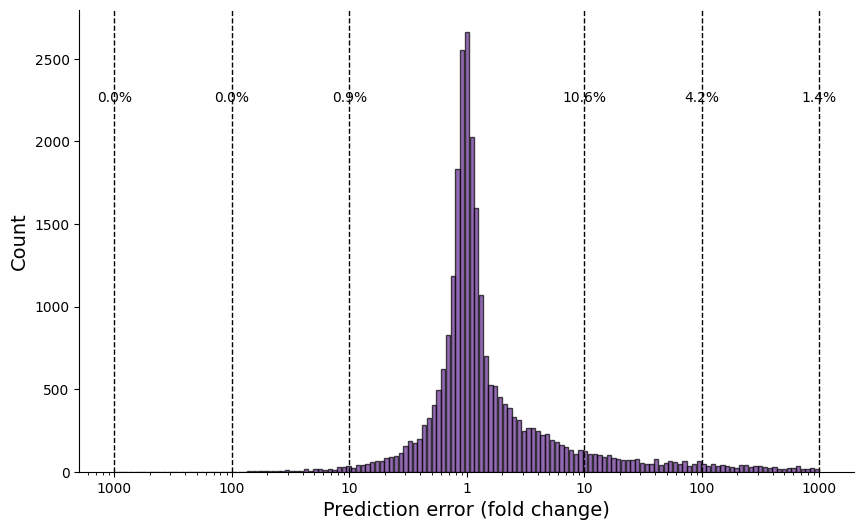

In [12]:

# 忽略警告
warnings.filterwarnings("ignore")

# 定义 DNN 模型和参数网格
dnn = MLPRegressor(max_iter=2000, random_state=42,solver='adam')
dnn_param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (150,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'logistic', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01]
}
endpoint = data['endpoint']

# 搜索最优参数
print("Training DNN...")
best_params_dnn, all_similarity_scores, all_errors, all_y_true, all_y_pred, endpoint_errors, all_smiles_embeddings = perform_random_search_cv(
    dnn, dnn_param_grid, X, y, smiles_data, endpoint, smiles_embeddings
)

# 输出最优参数
print("Best Parameters for DNN:", best_params_dnn)

# 综合评估
r2 = r2_score(all_y_true, all_y_pred)
mae = mean_absolute_error(all_y_true, all_y_pred)
rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
pearson_r, _ = pearsonr(all_y_true, all_y_pred)

print("\nOverall Evaluation Metrics:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Pearson R: {pearson_r:.4f}")

# 输出不同 endpoint 的平均绝对误差
print("\nEndpoint-wise Mean Absolute Errors:")
for endpoint, errors in endpoint_errors.items():
    mean_error = np.mean(errors)
    print(f"Endpoint {endpoint}: MAE = {mean_error:.4f}")

# 保存真实值和预测值以便后续分析
results_df = pd.DataFrame({
    'y_true': all_y_true,
    'y_pred': all_y_pred
})
results_df.to_csv("./unique/MT_dnn_evaluation_results.csv", index=False)

np.save("./unique/MT_dnn_val_smiles_embeddings.npy", np.array(all_smiles_embeddings))
print("Results and embeddings saved.")



all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)


errors_data = np.abs(all_y_true-all_y_pred)
    # 计算 MAD 和 SEM
median = np.median(errors_data)
MAD = np.median(np.abs(errors_data - median))
SEM = np.std(errors_data, ddof=1) / np.sqrt(len(errors_data))
    
print("DNN Model - MAD:", MAD, "SEM:", SEM)

plot_fold_change_histogram_symmetric(all_y_true, all_y_pred)

Training XGBoost...


Hyperparameter Search: 100%|██████████| 20/20 [1:29:20<00:00, 268.02s/it]


Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
XGBoost Model Evaluation Results with Cosine Similarity Groups:
High Similarity: Mean Absolute Error = nan (0.0%)
Intermediate Similarity: Mean Absolute Error = 0.4468 (24.2%)
Low Similarity: Mean Absolute Error = 0.6679 (75.8%)

Overall Evaluation Metrics:
R²: 0.7531
MAE: 0.6144
RMSE: 0.9015
Pearson R: 0.8695

Endpoint-wise Mean Absolute Errors:
Endpoint EC10: MAE = 0.6835
Endpoint EC50: MAE = 0.5682
Endpoint LC50: MAE = 0.5873
Results and embeddings saved.
XGBoost Model - MAD: 0.23673953430032757 SEM: 0.00402176442469021


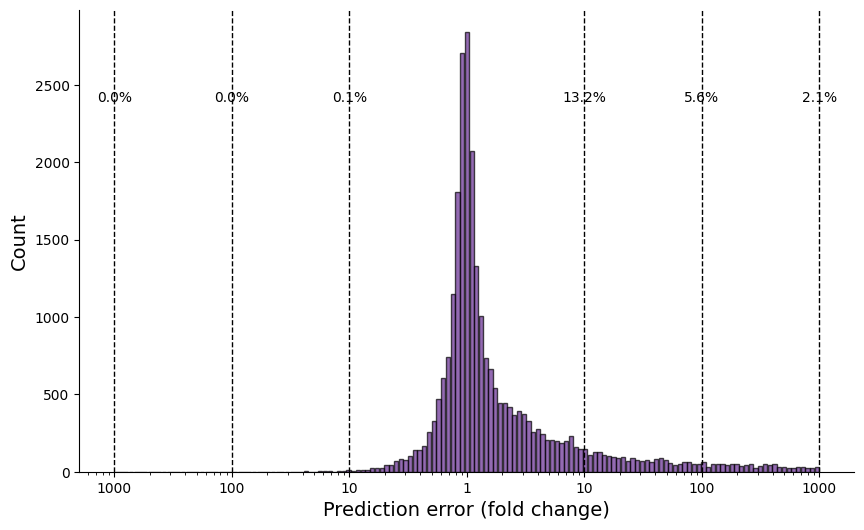

In [11]:

warnings.filterwarnings("ignore")

# 定义 XGBoost 模型和参数网格
xgb = XGBRegressor(verbose=0, n_jobs=-1)
xgb_param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
endpoint = data['endpoint']

# 搜索最优参数
print("Training XGBoost...")
best_params_xgb, all_similarity_scores, all_errors, all_y_true, all_y_pred, endpoint_errors, all_smiles_embeddings = perform_random_search_cv(
    xgb, xgb_param_grid, X, y, smiles_data, endpoint, smiles_embeddings
)

# 输出最优参数
print("Best Parameters for XGBoost:", best_params_xgb)


# 根据所有折的相似度和误差进行分组
fold_results = {'High Similarity': [], 'Intermediate Similarity': [], 'Low Similarity': []}
group_counts = {'High Similarity': 0, 'Intermediate Similarity': 0, 'Low Similarity': 0}

# 分组并计算每个分组的平均误差
for label, mask in zip(
    ['High Similarity', 'Intermediate Similarity', 'Low Similarity'],
    [np.array(all_similarity_scores) > 0.3,
     (np.array(all_similarity_scores) <= 0.3) & (np.array(all_similarity_scores) > 0.2),
     np.array(all_similarity_scores) <= 0.2]
):
    group_errors = np.array(all_errors)[mask]
    if len(group_errors) > 0:
        fold_results[label].append(np.mean(group_errors))
        group_counts[label] += len(group_errors)

# 计算每个相似度分组的样本百分比
total_count = sum(group_counts.values())
group_percentages = {key: (count / total_count) * 100 for key, count in group_counts.items()}

# 输出结果
print("XGBoost Model Evaluation Results with Cosine Similarity Groups:")
for group, scores in fold_results.items():
    score = np.mean(scores) if scores else float('nan')
    print(f"{group}: Mean Absolute Error = {score:.4f} ({group_percentages[group]:.1f}%)")




# 综合评估
r2 = r2_score(all_y_true, all_y_pred)
mae = mean_absolute_error(all_y_true, all_y_pred)
rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
pearson_r, _ = pearsonr(all_y_true, all_y_pred)

print("\nOverall Evaluation Metrics:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Pearson R: {pearson_r:.4f}")

# 输出不同 endpoint 的平均绝对误差
print("\nEndpoint-wise Mean Absolute Errors:")
for endpoint, errors in endpoint_errors.items():
    mean_error = np.mean(errors)
    print(f"Endpoint {endpoint}: MAE = {mean_error:.4f}")

# 保存结果
results_df = pd.DataFrame({'y_true': all_y_true, 'y_pred': all_y_pred})
results_df.to_csv("./unique/MT_xgboost_evaluation_results.csv", index=False)
np.save("./unique/MT_xgboost_val_smiles_embeddings.npy", np.array(all_smiles_embeddings))
print("Results and embeddings saved.")


all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)


errors_data = np.abs(all_y_true-all_y_pred)
    # 计算 MAD 和 SEM
median = np.median(errors_data)
MAD = np.median(np.abs(errors_data - median))
SEM = np.std(errors_data, ddof=1) / np.sqrt(len(errors_data))
    
print("XGBoost Model - MAD:", MAD, "SEM:", SEM)

plot_fold_change_histogram_symmetric(all_y_true, all_y_pred)



Training LightGBM...


Hyperparameter Search: 100%|██████████| 20/20 [28:59<00:00, 86.96s/it] 


Best Parameters for LightGBM: {'num_leaves': 31, 'n_estimators': 500, 'learning_rate': 0.01, 'feature_fraction': 0.8, 'bagging_fraction': 0.8}
LightGBM Model Evaluation Results with Cosine Similarity Groups:
High Similarity: Mean Absolute Error = nan (0.0%)
Intermediate Similarity: Mean Absolute Error = 0.4009 (24.2%)
Low Similarity: Mean Absolute Error = 0.6447 (75.8%)

Overall Evaluation Metrics:
R²: 0.7582
MAE: 0.5857
RMSE: 0.8921
Pearson R: 0.8709

Endpoint-wise Mean Absolute Errors:
Endpoint EC10: MAE = 0.6427
Endpoint EC50: MAE = 0.5473
Endpoint LC50: MAE = 0.5637
Results and embeddings saved.
LightGBM Model - MAD: 0.24736542347583645 SEM: 0.004101907760151552


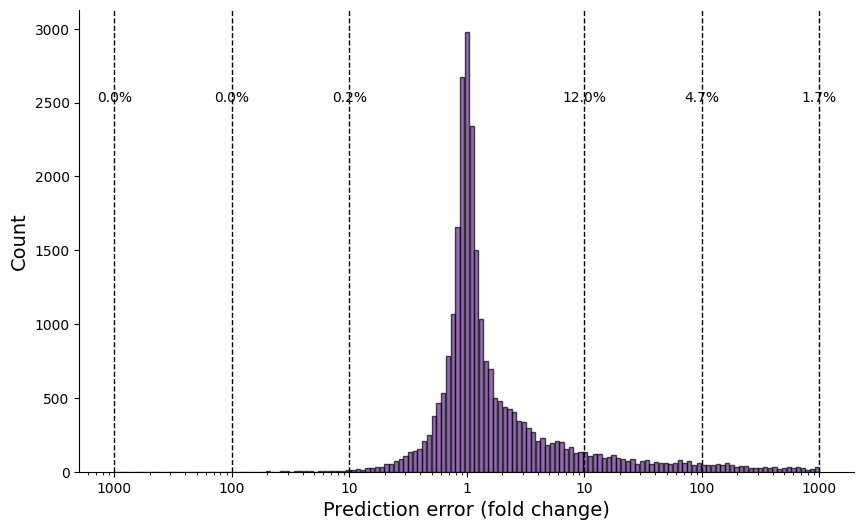

In [10]:
# 定义 LightGBM 模型和参数网格
lgbm = LGBMRegressor(verbose=-1, n_jobs=-1)
lgbm_param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [31, 50, 70, 100],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0]
}


endpoint = data['endpoint']
# 搜索最优参数
print("Training LightGBM...")
best_params_lgbm, all_similarity_scores, all_errors, all_y_true, all_y_pred, endpoint_errors, all_smiles_embeddings = perform_random_search_cv(
    lgbm, lgbm_param_grid, X, y, smiles_data, endpoint, smiles_embeddings
)

# 输出最优参数
print("Best Parameters for LightGBM:", best_params_lgbm)

# 根据所有折的相似度和误差进行分组
fold_results = {'High Similarity': [], 'Intermediate Similarity': [], 'Low Similarity': []}
group_counts = {'High Similarity': 0, 'Intermediate Similarity': 0, 'Low Similarity': 0}

# 分组并计算每个分组的平均误差
for label, mask in zip(
    ['High Similarity', 'Intermediate Similarity', 'Low Similarity'],
    [np.array(all_similarity_scores) > 0.3,
     (np.array(all_similarity_scores) <= 0.3) & (np.array(all_similarity_scores) > 0.2),
     np.array(all_similarity_scores) <= 0.2]
):
    group_errors = np.array(all_errors)[mask]
    if len(group_errors) > 0:
        fold_results[label].append(np.mean(group_errors))
        group_counts[label] += len(group_errors)

# 计算每个相似度分组的样本百分比
total_count = sum(group_counts.values())
group_percentages = {key: (count / total_count) * 100 for key, count in group_counts.items()}

# 输出结果
print("LightGBM Model Evaluation Results with Cosine Similarity Groups:")
for group, scores in fold_results.items():
    score = np.mean(scores) if scores else float('nan')
    print(f"{group}: Mean Absolute Error = {score:.4f} ({group_percentages[group]:.1f}%)")

# 综合评估
r2 = r2_score(all_y_true, all_y_pred)
mae = mean_absolute_error(all_y_true, all_y_pred)
rmse = np.sqrt(mean_squared_error(all_y_true, all_y_pred))
pearson_r, _ = pearsonr(all_y_true, all_y_pred)

print("\nOverall Evaluation Metrics:")
print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"Pearson R: {pearson_r:.4f}")

# 输出不同 endpoint 的平均绝对误差
print("\nEndpoint-wise Mean Absolute Errors:")
for endpoint, errors in endpoint_errors.items():
    mean_error = np.mean(errors)
    print(f"Endpoint {endpoint}: MAE = {mean_error:.4f}")

# 保存真实值和预测值以便后续分析
results_df = pd.DataFrame({
    'y_true': all_y_true,
    'y_pred': all_y_pred
})
results_df.to_csv("./unique/MT_lightgbm_evaluation_results.csv", index=False)
np.save("./unique/MT_lightgbm_val_smiles_embeddings.npy", np.array(all_smiles_embeddings))
print("Results and embeddings saved.")

all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)


errors_data = np.abs(all_y_true-all_y_pred)
    # 计算 MAD 和 SEM
median = np.median(errors_data)
MAD = np.median(np.abs(errors_data - median))
SEM = np.std(errors_data, ddof=1) / np.sqrt(len(errors_data))
    
print("LightGBM Model - MAD:", MAD, "SEM:", SEM)

plot_fold_change_histogram_symmetric(all_y_true, all_y_pred)